In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from utils.helpers import read_stock_data
from utils.plot import plot_predictions, plot_loss
from prepro.data_curation import create_preprocessing_pipeline, prepare_data, create_windows
from prepro.feature_eng import add_derived_features
from sklearn.preprocessing import MinMaxScaler
from post.eval_performance import log_returns_to_price, rescale_predictions
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

In [55]:
current_stock = "AAPL"
data = pd.read_csv(f"../archive/polygon/{current_stock}_latest.csv",  parse_dates=["Date"], date_format="%Y-%m-%d %H:%M:%S")
results = pd.read_csv(f"../results/{current_stock}/lstm_predictions_poly.csv")
data.head()

,open,high,low,close,volume,vwap,timestamp,transactions,otc,Date
0,188.28,189.980,187.61,189.70,45280027.0,189.1084,1693886400000,602458,NaN,2023-09-05 04:00:00
1,188.40,188.850,181.47,182.91,81755816.0,183.7860,1693972800000,880107,NaN,2023-09-06 04:00:00
2,175.18,178.210,173.54,177.56,112488803.0,176.7335,1694059200000,1210083,NaN,2023-09-07 04:00:00
3,178.35,180.239,177.79,178.18,65602066.0,179.0673,1694145600000,755390,NaN,2023-09-08 04:00:00
4,180.07,180.300,177.34,179.36,58953052.0,178.8465,1694404800000,722430,NaN,2023-09-11 04:00:00


In [57]:
true_1 = results["true_1"].values
pred_1 = results["pred_1"].values
true_1, pred_1, data["close"]

(array([ 0.0101011 , -0.00282181, -0.0041531 , -0.00089896, -0.01180854,
        -0.00923883, -0.02332909, -0.00361879, -0.03071113,  0.0249836 ,
         0.00104835, -0.00234783,  0.00449103,  0.00422308,  0.0077537 ,
        -0.00221626, -0.01085647,  0.01626534, -0.01218655,  0.00603783,
        -0.01938035,  0.00211066, -0.0139014 ,  0.00997805, -0.01410976,
         0.00479324,  0.02223543,  0.00248447, -0.00597314,  0.00627086,
        -0.0027822 ,  0.00039793,  0.02013606,  0.01283342,  0.02198728,
         0.0052114 , -0.01700159,  0.00028574,  0.00536627,  0.00599695,
        -0.00590223, -0.01210172,  0.00234601,  0.00500872, -0.00066638,
         0.00550809,  0.00613702,  0.00899556, -0.00116673, -0.00182281,
         0.00056122,  0.00079452, -0.0130727 , -0.01056348, -0.00710483,
        -0.02532151,  0.00478151, -0.00211682,  0.04965337,  0.03129871,
         0.04148532, -0.00950657,  0.01081376,  0.01589735, -0.00235996,
        -0.00512523, -0.00302716, -0.00143027, -0.0

In [63]:
X, y = prepare_data(data, 7)
test_size = min(int(0.15 * X.shape[0]), 10000)
y_test = y[-test_size + 2:]
y_test[:, 0]

array([ 0.0101011 , -0.00282181, -0.0041531 , -0.00089896, -0.01180854,
       -0.00923883, -0.02332909, -0.00361879, -0.03071113,  0.0249836 ,
        0.00104835, -0.00234783,  0.00449103,  0.00422308,  0.0077537 ,
       -0.00221626, -0.01085647,  0.01626534, -0.01218655,  0.00603783,
       -0.01938035,  0.00211066, -0.0139014 ,  0.00997805, -0.01410976,
        0.00479324,  0.02223543,  0.00248447, -0.00597314,  0.00627086,
       -0.0027822 ,  0.00039793,  0.02013606,  0.01283342,  0.02198728,
        0.0052114 , -0.01700159,  0.00028574,  0.00536627,  0.00599695,
       -0.00590223, -0.01210172,  0.00234601,  0.00500872, -0.00066638,
        0.00550809,  0.00613702,  0.00899556, -0.00116673, -0.00182281,
        0.00056122,  0.00079452, -0.0130727 , -0.01056348, -0.00710483,
       -0.02532151,  0.00478151, -0.00211682,  0.04965337,  0.03129871,
        0.04148532, -0.00950657,  0.01081376,  0.01589735, -0.00235996,
       -0.00512523, -0.00302716, -0.00143027, -0.01993189, -0.00

In [65]:
y_compare = log_returns_to_price(y_test[:, 0], data["close"].iloc[-test_size - 1])
y_true = log_returns_to_price(true_1, data["close"].iloc[-test_size - 1])
y_pred = log_returns_to_price(pred_1, data["close"].iloc[-test_size - 1])
y_compare, y_true, y_pred

(array([[213.40477157, 212.80343375, 211.92147161, 211.73104796,
         209.24551829, 207.32123725, 202.54060155, 201.80897386,
         195.70539494, 200.6564097 , 200.86687794, 200.39582997,
         201.29783671, 202.14973196, 203.7232326 , 203.27222923,
         201.07734617, 204.37468191, 201.89917453, 203.12189478,
         199.22322122, 199.64415769, 196.888026  , 198.86241852,
         196.07621993, 197.01831586, 201.44817117, 201.94928602,
         200.74661037, 202.0094198 , 201.44817117, 201.52834954,
         205.62746905, 208.28337777, 212.91367902, 214.02615399,
         210.41812705, 210.47826083, 211.6107804 , 212.88361213,
         211.63082499, 209.08516154, 209.57625409, 210.62859528,
         210.48828313, 211.65086959, 212.95376821, 214.87804924,
         214.62749182, 214.23662223, 214.3568898 , 214.52726885,
         211.74107026, 209.51612031, 208.03282034, 202.83124816,
         203.80341098, 203.3724522 , 213.72548508, 220.5206025 ,
         229.86138337, 22

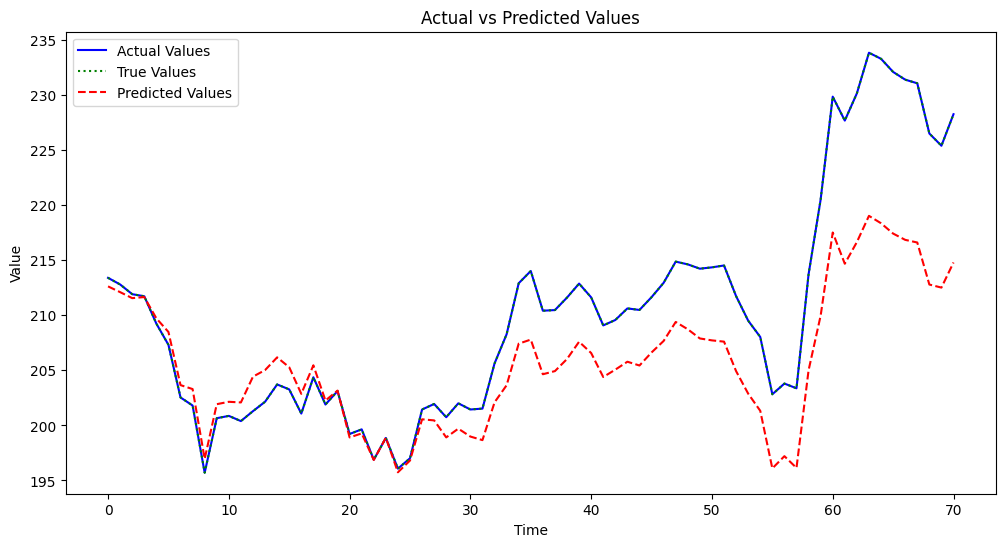

In [71]:
# Create a new figure
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(y_compare.reshape(-1), color="blue", label="Actual Values")
plt.plot(y_true.reshape(-1), color="green", linestyle="dotted", label="True Values")
# Plot predicted values
plt.plot(y_pred.reshape(-1), color="red", linestyle="dashed", label="Predicted Values")

# plt.ylim(0, 200)
# Add labels and title
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Actual vs Predicted Values")
plt.legend()
plt.show()

In [68]:
up_results = pd.read_csv(f"../results/{current_stock}/lstm_predictions_poly.csv")
up_results.head()

,pred_1,true_1,pred_2,true_2,pred_3,true_3,pred_4,true_4,pred_5,true_5,pred_6,true_6,pred_7,true_7
0,0.006459,0.010101,0.000959,-0.002822,-0.003778,-0.004153,-0.005161,-0.000899,-0.001807,-0.011809,0.002245,-0.009239,0.000730,-0.023329
1,-0.002463,-0.002822,0.000394,-0.004153,-0.005797,-0.000899,-0.005359,-0.011809,-0.005842,-0.009239,0.002933,-0.023329,-0.002661,-0.003619
2,-0.002569,-0.004153,0.000559,-0.000899,-0.007040,-0.011809,-0.004413,-0.009239,-0.005540,-0.023329,0.002266,-0.003619,-0.003700,-0.030711
3,0.000464,-0.000899,0.000324,-0.011809,-0.007988,-0.009239,-0.004812,-0.023329,-0.005461,-0.003619,0.001320,-0.030711,-0.004413,0.024984
4,-0.009180,-0.011809,-0.001761,-0.009239,-0.006638,-0.023329,-0.001479,-0.003619,-0.004532,-0.030711,0.002979,0.024984,-0.003854,0.001048


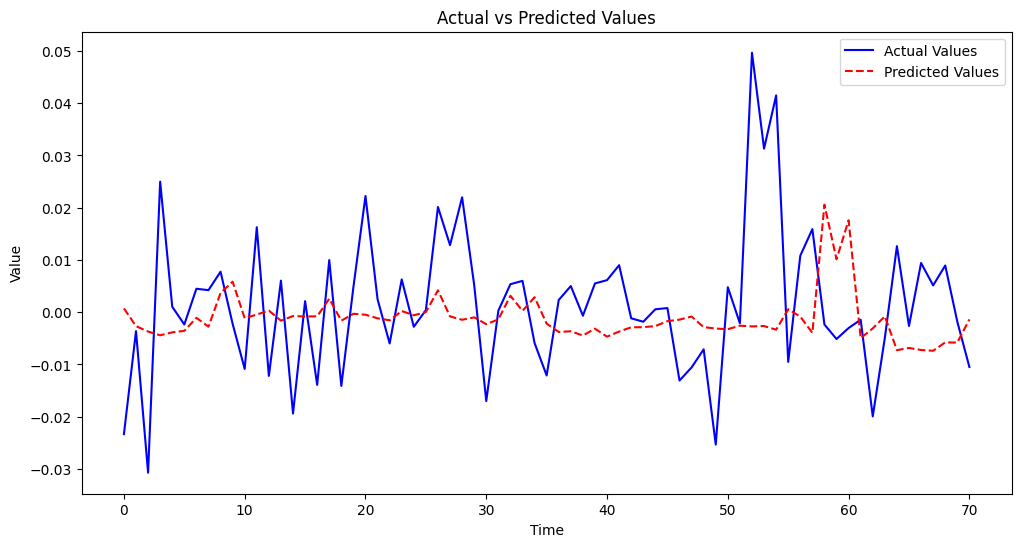

In [77]:
# Create a new figure
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(up_results["true_7"], color="blue", label="Actual Values")

# Plot predicted values
plt.plot(up_results["pred_7"], color="red", linestyle="dashed", label="Predicted Values")

# Add labels and title
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Actual vs Predicted Values")
plt.legend()
plt.show()

In [ ]:
init_up = 211.45
prices_true, prices = rescale_predictions(up_results["true_1"], up_results["pred_1"], y_scaler)
prices.shape, prices_true

c:\Users\pasca\Documents\Playground\AlgoTrading\src\post\eval_performance.py:23: RuntimeWarning: overflow encountered in exp
  return initial_price * np.exp(np.cumsum(log_returns, axis=1))


((1, 69),
 array([[9.34153635e+008, 1.13063940e+016, 1.63166209e+023,
         2.24138099e+030, 2.86407378e+037, 3.60304356e+044,
         3.69671660e+051, 3.23904317e+058, 1.91744619e+065,
         1.06897573e+072, 3.61237608e+078, 1.83223588e+085,
         9.45511978e+091, 4.69432530e+098, 2.50963345e+105,
         1.43877646e+112, 9.38484362e+118, 5.89922925e+125,
         3.09726347e+132, 2.13116741e+139, 1.19694812e+146,
         7.43170391e+152, 3.35138472e+159, 1.56442456e+166,
         5.82514856e+172, 2.55029551e+179, 8.88433683e+185,
         3.34363249e+192, 1.80971761e+199, 1.02059544e+206,
         5.21501002e+212, 2.95556166e+219, 1.59967700e+226,
         8.71526629e+232, 6.64578707e+239, 6.30115313e+246,
         8.73439071e+253, 1.32639657e+261, 1.49827072e+268,
         1.70078438e+275, 2.11860719e+282, 2.92948981e+289,
         3.65516676e+296, 3.70119245e+303,             inf,
                     inf,             inf,             inf,
                     inf,     